To Do:

- chase down missing points, make list of the coins.
- partial dependence graphs: fix overlap
- RLS M-estimator
- make latex compatible output graphs


In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, rlm
from statsmodels.iolib.summary2 import summary_col

from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge


from mpl_toolkits.mplot3d import Axes3D

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from sklearn.linear_model import Lasso, LassoCV, ElasticNetCV, ElasticNet

from patsy import dmatrices
from sklearn_pandas import DataFrameMapper, cross_val_score
import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics

In [63]:
l=["data/forumAND.csv",
   'data/forumOR.csv']


degree_vars = ['user1_degree_total',
           'user1_degree_incoming', 'user1_degree_outgoing',]

graph_vars=       ['user1_clustering_coefficient',
                    'user1_closeness_centrality_unweighted']
              #     'user1_betweenness_centrality_unweighted']
                   
#           'user1_closeness_centrality_incoming_unweighted',
#           'user1_closeness_centrality_outgoing_unweighted']

satoshi_vars=       ['user1_satoshi_distance',
            'user1_satoshi_pagerank_weighted',
            'user1_satoshi_distance_inf']

weighted_vars=       [ 'user1_pagerank_weighted',
                      'user1_closeness_centrality_weighted',
                    'user1_betweenness_centrality_weighted',]
#           'user1_closeness_centrality_incoming_weighted',
#           'user1_closeness_centrality_outgoing_weighted']

interacted_technical = ['user1_closeness_centrality_weighted:nontrivial',
                        'user1_betweenness_centrality_weighted:nontrivial',
                       'user1_clustering_coefficient:nontrivial']

technical_vars = ['nontrivial']


naive_vars = ['user1_num_posts', 'user1_num_subjects',
           'user1_days_since_first_post']




independent_vars =  naive_vars + graph_vars + satoshi_vars + technical_vars + degree_vars + weighted_vars
dependent_vars = ["log_volume","log_severity","log_market_num"]

In [64]:
def joint_dataset(fname, normalize =True, full=False):
    data = pd.read_csv( fname, 
    index_col='coin').join(pd.read_csv(
        'data/nontrivial.csv',index_col='coin')).join(pd.read_csv(
        'data/prices.csv',index_col='symbol',skipinitialspace=True))
    data['user1_years_since_first_post'] = data.user1_days_since_first_post/365.
    data['log_severity']=np.log(data['severity_to_average_after_max_volume_weighted'])
    data['log_volume']=np.log(data['total_volume'])
    data['log_market_num'] = np.log(np.e+data.market_num)
    
    data.loc[data.user1_satoshi_distance > 6,'user1_satoshi_distance_inf'] = 1
    data.loc[data.user1_satoshi_distance <= 6,'user1_satoshi_distance_inf'] = 0
    data.loc[data.user1_satoshi_distance > 6,'user1_satoshi_distance'] = 7 # the infs turn into 7s (highest is 6, there is only one)

    #the candidate features we will be using inthe analysis as our indepedent variables


    df= data[independent_vars+dependent_vars]

    #print data_norm
    if full : return data
    if normalize:    return (df - df.mean()) / (df.std())
    else: return df


In [65]:
#model_aic = LassoLarsIC(criterion='aic')
#model_aic.fit(np.array(X), np.array(y))
#print sm.OLS(y,X).fit(cov_type='HC3').summary() 

def fit_model(target,xvars,data_norm):
    formula = target + " ~ " + " + ".join(xvars)
    #print formula
    y,X = dmatrices(formula ,data_norm,return_type='dataframe' )
    X = sklearn.preprocessing.scale(X)
    y = sklearn.preprocessing.scale(y[target])
    reg_para = [0.0001,0.001, 0.0025,0.005,0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.5, 1, 5, 10, 50, 100]
    l1_ratios  =[.1, .5, .7, .9, .95, .99,.999, 1]
    lasso_model = ElasticNetCV(cv=5 , alphas=reg_para, selection='random',  l1_ratio=l1_ratios) #LOO CV works better than k fold
    lasso_fit = lasso_model.fit(X,y)
    #print lasso_fit.alpha_# ,lasso_fit.coef_
    selected = ["1"]
    for i,x in enumerate(lasso_fit.coef_[1:]): #skip the constant
        if x != 0.: selected.append(xvars[i])
    ols_results =ols(target + " ~ " + " + ".join(selected) ,data_norm).fit_regularized( L1_wt=0.999, alpha=lasso_fit.alpha_)
    #ols_results.mse = lasso_fit.mse_path_[l1_ratios.index(lasso_fit.l1_ratio_)]
    ols_results.mse =  (np.mean(lasso_fit.mse_path_[l1_ratios.index(lasso_fit.l1_ratio_)]) )
    ols_results.alpha = lasso_fit.alphas.index(lasso_fit.alpha_)
    ols_results.l1_ratio = lasso_fit.l1_ratio_
    return  ols_results
#shape = (n_l1_ratio, n_alpha, n_folds)

In [66]:

def make_regression_tables(yvar,datasets):
    for f in l:
        data_norm = joint_dataset(f)
        res = summary_col([fit_model(yvar,naive_vars  + degree_vars,data_norm),
                           fit_model(yvar, technical_vars ,data_norm),
                           fit_model(yvar,naive_vars  + degree_vars + technical_vars   ,data_norm),
                           fit_model(yvar,naive_vars  + degree_vars + technical_vars   + graph_vars,data_norm),
                           fit_model(yvar,naive_vars  + degree_vars + technical_vars  + weighted_vars,data_norm),
                           fit_model(yvar,naive_vars  + degree_vars + technical_vars  + graph_vars + interacted_technical ,data_norm), 
                           fit_model(yvar,independent_vars,data_norm)],
                          stars=True,float_format='%0.2f',
                      model_names=['Activity','Nontrivial','Satoshi','Network','Weighted','Network*Nontrivial','All'],
                      info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                 'R2':lambda x: "{:.2f}".format(x.rsquared),
                                 'Adjusted-R2':lambda x: "{:.2f}".format(x.rsquared_adj),
                                 #'AIC':lambda x: "{:.2f}".format(x.aic),
                                 'BIC':lambda x: "{:.0f}".format(x.bic),
                                 'Condition Number':lambda x: "{:.2f}".format(x.condition_number),
                                 'ElasticNet CV MSE:' :lambda x: "{:.2f}".format(x.mse),
                                 #'ElasticNet CV  L1 ratio':lambda x: "{:.2f}".format( x.l1_ratio),
                                 #'ElasticNet CV alpha':lambda x: "{:.2f}".format( x.alpha)
                                })
        
        open("tables/"+yvar +"_models "+ f[5:-4]+".tex","w").write(res.as_latex())
        print res




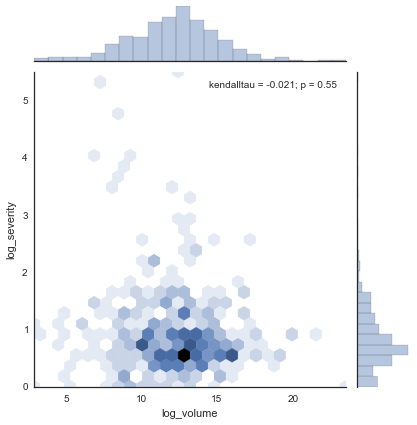

In [67]:
#descriptive graphs
data = joint_dataset(l[0], normalize=False)
data_norm = joint_dataset(l[0], normalize=True)

from scipy.stats import kendalltau

sns.set(style="white")

sns.jointplot(data.log_volume, data.log_severity, kind="hex", stat_func=kendalltau)#, color="#4CB391")


In [107]:
#"data/directed_unlimited/unmodified_symbol_and_name_in_subject_with_ANN_first_thread_post_introducers_metrics.csv"]
#  "data/directed_unlimited/unmodified_symbol_and_name_in_subject_with_[ANN]_first_thread_post_introducers_metrics.csv"]
# "data/directed_unlimited/unmodified_symbol_or_name_in_subject_with_ANN_first_thread_post_introducers_metrics.csv"]

make_regression_tables("log_volume",l)




                                               Activity Nontrivial Satoshi Network Weighted Network*Nontrivial   All   
-----------------------------------------------------------------------------------------------------------------------
Intercept                                      0.00     0.00       0.00    0.00    0.00     0.00               0.00    
                                               (0.00)   (0.00)     (0.00)  (0.00)  (0.00)   (0.00)             (0.00)  
nontrivial                                              0.15***    0.13**  0.06    0.04     0.02               0.11**  
                                                        (0.05)     (0.05)  (0.05)  (0.05)   (0.05)             (0.05)  
user1_betweenness_centrality_weighted                                              0.00                        -0.04   
                                                                                   (0.00)                      (0.08)  
user1_closeness_centrality_unweighted  

In [108]:
make_regression_tables("log_severity",l)



                                               Activity Nontrivial Satoshi Network Weighted Network*Nontrivial   All  
----------------------------------------------------------------------------------------------------------------------
Intercept                                      0.00     0.00       0.00    0.00    0.00     0.00               0.00   
                                               (0.00)   (0.00)     (0.00)  (0.00)  (0.00)   (0.00)             (0.00) 
nontrivial                                                                         0.00                               
                                                                                   (0.00)                             
user1_betweenness_centrality_weighted                                                                          0.00   
                                                                                                               (0.00) 
user1_closeness_centrality_unweighted          

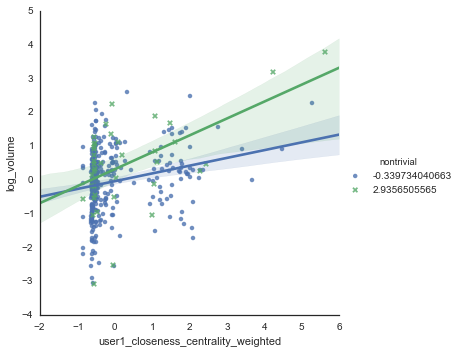

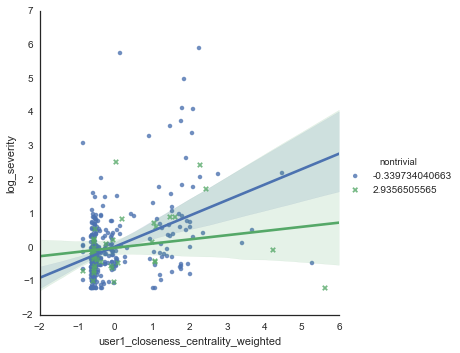

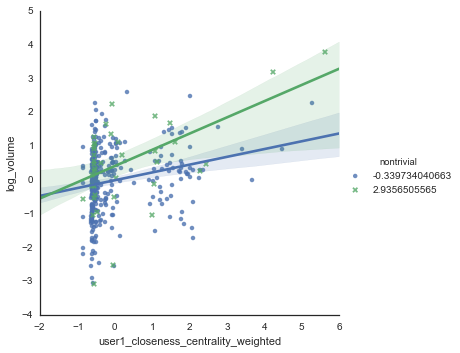

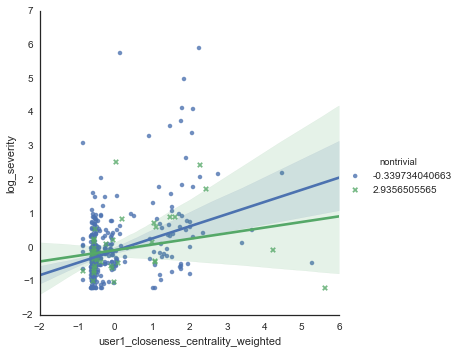

In [96]:
# (data[naive_vars  + degree_vars + technical_vars + satoshi_vars + weighted_vars])
sns.lmplot('user1_closeness_centrality_weighted','log_volume',hue='nontrivial',markers=["o", "x"], data=data_norm,n_boot=1000)
sns.lmplot('user1_closeness_centrality_weighted','log_severity',hue='nontrivial',markers=["o", "x"], data=data_norm,n_boot=1000)

sns.lmplot('user1_closeness_centrality_weighted','log_volume',hue='nontrivial',markers=["o", "x"],robust=True, data=data_norm,n_boot=1000)
sns.lmplot('user1_closeness_centrality_weighted','log_severity',hue='nontrivial',markers=["o", "x"],robust=True, data=data_norm,n_boot=1000)

#sns.lmplot('user1_degree_outgoing','log_volume', data_norm)

#they are identical correlation 1 ish('user1_closeness_centrality_outgoing_unweighted','user1_closeness_centrality_outgoing_weighted',data)

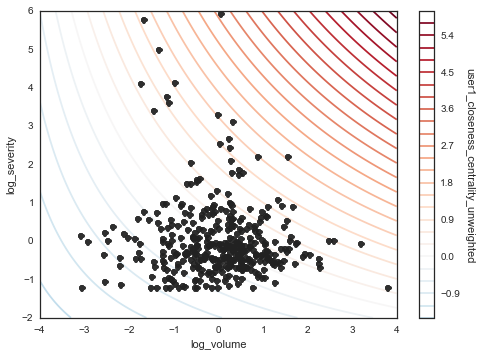

In [70]:
sns.interactplot("log_volume", "log_severity", "user1_closeness_centrality_unweighted", data_norm )

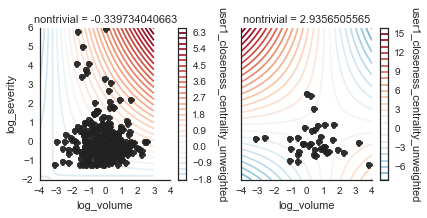

In [71]:
g = sns.FacetGrid(data_norm, col="nontrivial")
g.map(sns.interactplot,"log_volume", "log_severity",'user1_closeness_centrality_unweighted');

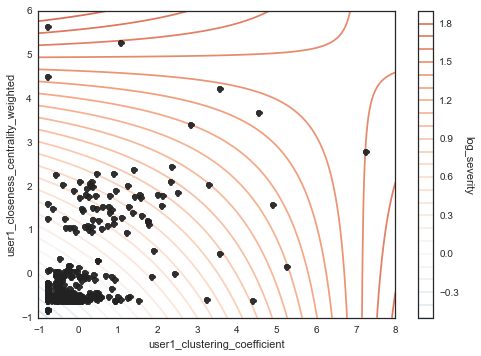

In [72]:
sns.interactplot("user1_clustering_coefficient", "user1_closeness_centrality_weighted", "log_severity", data_norm )


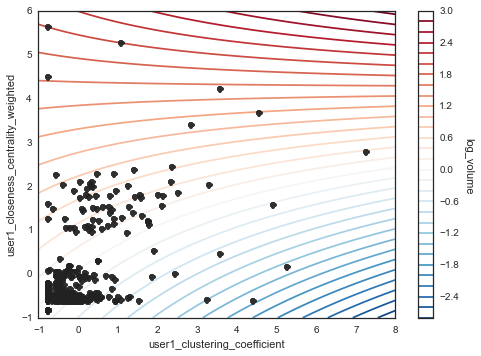

In [97]:
sns.interactplot("user1_clustering_coefficient", "user1_closeness_centrality_weighted", "log_volume", data_norm )

In [100]:

#"log_volume ~ user1_num_posts +user1_days_since_first_post + technical +  user1_closeness_centrality_unweighted + user1_clustering_coefficient"
y,X = dmatrices( "log_volume" +  " ~ " + " + ".join(naive_vars  + degree_vars + technical_vars + satoshi_vars + weighted_vars) ,data_norm,return_type='dataframe' )
#y,X = dmatrices("log_volume" +  " ~ " + " + ".join(naive_vars  + degree_vars + graph_vars),data,return_type='dataframe')
names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])
offset = int(X.shape[0] * 0.80)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# split 80/20 train-test

print('_' * 80)
print("Training GBRT...")
clf_cv =  GridSearchCV(GradientBoostingRegressor(n_estimators=10, max_depth=6,
                                learning_rate=0.01, loss='ls',
                                random_state=1),
                  param_grid={"learning_rate": np.logspace(-2,-1,0,1, 2,3,4,5,6,7,8,9, 5),
                             "n_estimators":[5,10,25,50,100], "max_depth":[2,4,6,8]})


clf_cv.fit(X_train, y_train)


clf = clf_cv.best_estimator_

print clf_cv.best_score_

print clf.score(X_test, y_test)



features = [ 2, 3, 4,5] # REVISE THIS WITH NEW COINS AVAILABLE
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence of volume on network features')
plt.subplots_adjust()  # tight_layout causes overlap with suptitle top=1.2
fig = plt.figure()

target_feature = (4, 5)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of volume')
plt.subplots_adjust(top=0.9)





SyntaxError: invalid syntax (<ipython-input-100-5a1f03feab3d>, line 19)

In [101]:

make_regression_tables("log_market_num",l)



                                               Activity Nontrivial Satoshi Network Weighted Network*Nontrivial   All  
----------------------------------------------------------------------------------------------------------------------
Intercept                                      0.00     0.00       0.00    0.00    0.00     0.00               0.00   
                                               (0.00)   (0.00)     (0.00)  (0.00)  (0.00)   (0.00)             (0.00) 
nontrivial                                              0.22***    0.20*** 0.11**  0.15***  0.08*              0.13***
                                                        (0.05)     (0.05)  (0.05)  (0.05)   (0.05)             (0.05) 
user1_closeness_centrality_unweighted                                      0.15***          0.11**             0.00   
                                                                           (0.05)           (0.05)             (0.00) 
user1_closeness_centrality_weighted            

________________________________________________________________________________
Training GBRT...
0.0353985281081
0.0567537127896
________________________________________________________________________________
Custom 3d plot via ``partial_dependence``



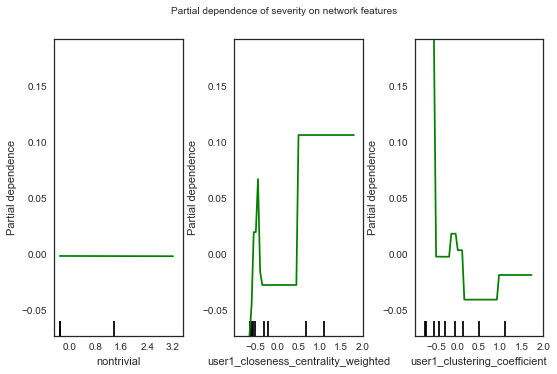

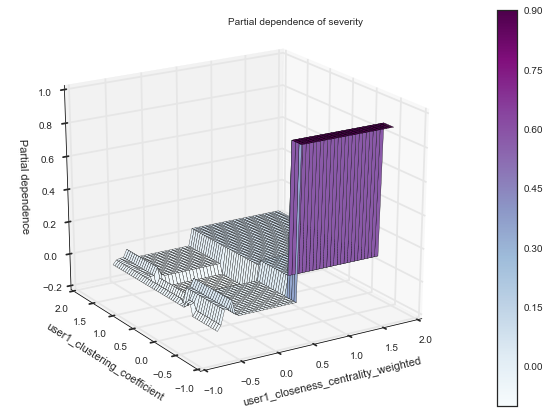

In [105]:
yvar,independent_vars,data_norm

data_norm =  joint_dataset(l[1])
y,X = dmatrices("log_severity ~  nontrivial +  user1_closeness_centrality_weighted + user1_clustering_coefficient"  ,data_norm,return_type='dataframe' )
names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])
offset = int(X.shape[0] * 0.80)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# split 80/20 train-test

print('_' * 80)
print("Training GBRT...")
clf_cv =  GridSearchCV(GradientBoostingRegressor(n_estimators=10, max_depth=6,
                                learning_rate=0.01, loss='ls',
                                random_state=1),
                  param_grid={"learning_rate": np.logspace(-2, 2, 5),
                             "n_estimators":[5,10,25,50,100], "max_depth":[2,4,6,8]})


clf_cv.fit(X_train, y_train)


clf = clf_cv.best_estimator_

print clf_cv.best_score_

print clf.score(X_test, y_test)


#print('_' * 80)
#print('Convenience plot with ``partial_dependence_plots``')
#print

features = [1, 2, 3 ]
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence of severity on network features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (2, 3)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=-122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of severity')
plt.subplots_adjust(top=0.9)

plt.show()

________________________________________________________________________________
Training GBRT...
0.039676587058
0.176522228625
________________________________________________________________________________
Custom 3d plot via ``partial_dependence``



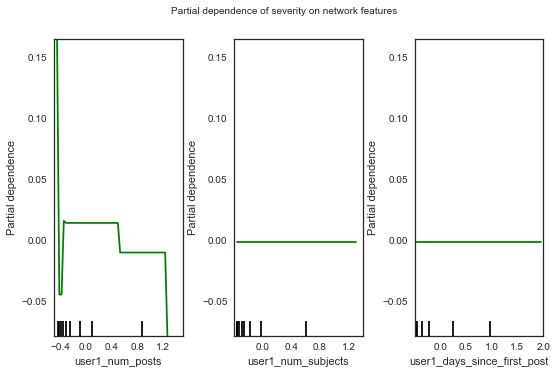

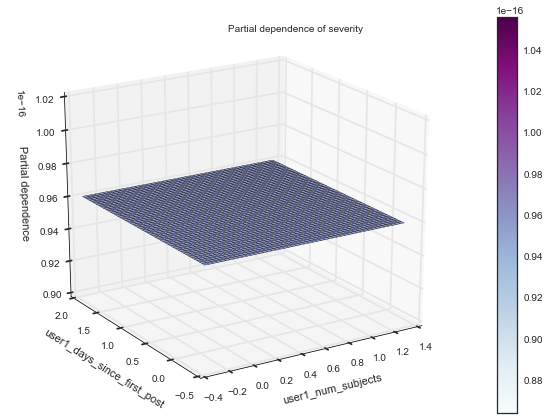

In [106]:

data_norm =  joint_dataset(l[1])
y,X = dmatrices("log_severity ~  " + "+".join(independent_vars)  ,data_norm,return_type='dataframe' )
names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])
offset = int(X.shape[0] * 0.80)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# split 80/20 train-test

print('_' * 80)
print("Training GBRT...")
clf_cv =  GridSearchCV(GradientBoostingRegressor(n_estimators=10, max_depth=6,
                                learning_rate=0.01, loss='ls',
                                random_state=1),
                  param_grid={"learning_rate": np.logspace(-2, 2, 5),
                             "n_estimators":[5,10,25,50,100], "max_depth":[2,4,6,8]})


clf_cv.fit(X_train, y_train)


clf = clf_cv.best_estimator_

print clf_cv.best_score_

print clf.score(X_test, y_test)


#print('_' * 80)
#print('Convenience plot with ``partial_dependence_plots``')
#print

features = [1, 2, 3 ]
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence of severity on network features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (2, 3)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=-122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of severity')
plt.subplots_adjust(top=0.9)

plt.show()

In [ ]:


y,X = dmatrices("log_market_num ~  technical  + user1_closeness_centrality_outgoing_unweighted + user1_clustering_coefficient + user1_degree_incoming  "  ,data,return_type='dataframe' )
names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_market_num'])
offset = int(X.shape[0] * 0.8)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# split 80/20 train-test

print('_' * 80)
print("Training GBRT...")
clf = GradientBoostingRegressor(n_estimators=10, max_depth=6,
                                learning_rate=0.01, loss='ls',
                                random_state=1)
clf.fit(X_train, y_train)
print("done.")

print('_' * 80)
print('Convenience plot with ``partial_dependence_plots``')
print

features = [1,2,3]
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence of market num on network features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (3, 2)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=-122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of market num')
plt.subplots_adjust(top=0.9)

plt.show()

In [ ]:
sns.lmplot('user1_closeness_centrality_unweighted','log_volume',data)#,hue='technical')

In [ ]:
sns.lmplot('user1_closeness_centrality_unweighted','log_volume',data_norm, hue='technical')

In [ ]:
sns.lmplot('user1_years_since_first_post','user1_num_posts',data,robust=True)

In [ ]:
sns.lmplot("log_severity", "log_volume",data,hue='type')

In [ ]:
sns.lmplot("log_severity_to_last", "log_total_volume",data,hue='type', robust=True)

In [ ]:
sns.lmplot("log_severity_to_last", "log_total_volume",data,hue='type', lowess=True)

In [ ]:
data.finite_satoshi_distance.describe()

In [ ]:
from sklearn import cross_validation, linear_model
import matplotlib.pyplot as plt
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')


lasso_cv = linear_model.LassoCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 5)
scores=[]
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X[train], y[train])
    s=lasso_cv.score(X[test], y[test])
    scores.append(s)
print "Average out of sample score on cross validation %f"% np.average(scores)


In [ ]:
from sklearn import cross_validation, linear_model
import matplotlib.pyplot as plt
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')


lasso_cv = linear_model.LassoCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 5)
scores=[]
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X[train], y[train])
    s=lasso_cv.score(X[test], y[test])
    scores.append(s)
print "Average out of sample score on cross validation %f"% np.average(scores)


In [ ]:
from sklearn.grid_search import  RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

clf = RandomForestRegressor(n_estimators=20)
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])



# specify parameters and distributions to sample from
param_dist = {"max_depth": [2, None],
              "max_features": sp_randint(1, len(X[1])),
              "min_samples_split": sp_randint(1, len(X[1])),
              "min_samples_leaf": sp_randint(1, len(independent_vars)),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

In [ ]:
from sklearn.grid_search import  RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

clf = RandomForestRegressor(n_estimators=20)
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])



# specify parameters and distributions to sample from
param_dist = {"max_depth": [2, None],
              "max_features": sp_randint(1, len(X[1])),
              "min_samples_split": sp_randint(1, len(X[1])),
              "min_samples_leaf": sp_randint(1, len(independent_vars)),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

In [ ]:




from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

###############################################################################
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
feature_names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 1,
          'learning_rate': 0.001, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


# this may take some minutes
#gs_cv = GridSearchCV(ensemble.GradientBoostingRegressor, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
#print gs_cv.best_params_


###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:




from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

###############################################################################
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
feature_names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 1,
          'learning_rate': 0.001, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


# this may take some minutes
#gs_cv = GridSearchCV(ensemble.GradientBoostingRegressor, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
#print gs_cv.best_params_


###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.datasets.california_housing import fetch_california_housing


data_norm =  joint_dataset(f)
y,X = dmatrices("log_volume ~ user1_num_posts + user1_num_subjects + technical +  user1_closeness_centrality_unweighted + user1_clustering_coefficient"  ,data_norm,return_type='dataframe' )
names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])
offset = int(X.shape[0] * 0.8)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# split 80/20 train-test

print('_' * 80)
print("Training GBRT...")
clf = GradientBoostingRegressor(n_estimators=10, max_depth=6,
                                learning_rate=0.01, loss='ls',
                                random_state=1)
clf.fit(X_train, y_train)
print("done.")

print('_' * 80)
print('Convenience plot with ``partial_dependence_plots``')
print

features = [1, 2, 3, 4,5, (5, 4)]
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence of severity on network features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (4, 5)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=-122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of severity')
plt.subplots_adjust(top=0.9)

plt.show()

In [ ]:
sns.interactplot('user1_clustering_coefficient','user1_closeness_centrality_unweighted', 'log_severity', data=data)

In [ ]:
sns.interactplot('user1_clustering_coefficient','user1_closeness_centrality_unweighted', 'log_volume', data=data)

In [ ]:
sns.jointplot(x="log_severity", y="log_volume", data=data);

In [ ]:
sns.pairplot(data[['log_severity','log_volume']])

In [ ]:
sns.pairplot(tight_dataset)

In [ ]:
factor(data.user1_satoshi_distance)

In [ ]:
data['user1_num_mentions'].describe()

In [ ]:
"np.log(total_volume) ~ " + " + ".join(independent_vars)

In [ ]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(data[[
       u'user1_clustering_coefficient',
       u'user1_closeness_centrality_weighted',
       u'user1_closeness_centrality_incoming_weighted',
       u'user1_closeness_centrality_outgoing_weighted']], alpha=0.2, figsize=(15, 15), diagonal='kde')



In [ ]:
pd.read_csv(
    "directed_unlimited/unmodified_symbol_and_name_in_subject_with_[ANN]_first_thread_post_introducers_metrics.csv")

In [ ]:
print ols(formula="log_volume ~ user1_closeness_centrality_weighted+ user1_satoshi_distance + user1_satoshi_distance_inf" ,data=data).fit(cov_type='HC3').summary()
print ols(formula="log_severity ~ user1_closeness_centrality_weighted + user1_satoshi_distance + user1_satoshi_distance_inf" ,data=data).fit(cov_type='HC3').summary() 
print ols(formula="log_severity ~ user1_closeness_centrality_weighted*type" ,data=data).fit(cov_type='HC3').summary() 

sns.lmplot('user1_closeness_centrality_weighted','log_volume',data, hue='type')
sns.lmplot('user1_closeness_centrality_weighted','log_severity',data, hue='type')

In [ ]:
data.columns

In [ ]:
from statsmodels.sandbox import gam

In [ ]:

example = 1  # 1,2 or 3

import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

from statsmodels.sandbox.gam import AdditiveModel
from statsmodels.sandbox.gam import Model as GAM #?
from statsmodels.genmod.families import family
from statsmodels.genmod.generalized_linear_model import GLM

standardize = lambda x: (x - x.mean()) / x.std()
demean = lambda x: (x - x.mean())
target = 'log_volume'
y,X = dmatrices(target +" ~ " + " + ".join(independent_vars) ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y[target])
g= gam.AdditiveModel(X)
g.fit(y)


if example == 1:
    print("normal")
    m = AdditiveModel(X)
    m.fit(y)
    x = np.linspace(-2,2,50)

    print(m)

    y_pred = m.results.predict(X)
    plt.figure()
    plt.plot(y, '.')
    plt.plot(y_pred, 'r-', label='AdditiveModel')
    plt.legend()
    plt.title('gam.AdditiveModel')

import scipy.stats, time

if example == 2:
    print("binomial")
    f = family.Binomial()
    b = np.asarray([scipy.stats.bernoulli.rvs(p) for p in f.link.inverse(y)])
    b.shape = y.shape
    m = GAM(b, d, family=f)
    toc = time.time()
    m.fit(b)
    tic = time.time()
    print(tic-toc)


if example == 3:
    print("Poisson")
    f = family.Poisson()
    y = y/y.max() * 3
    yp = f.link.inverse(y)
    p = np.asarray([scipy.stats.poisson.rvs(p) for p in f.link.inverse(y)], float)
    p.shape = y.shape
    m = GAM(p, d, family=f)
    toc = time.time()
    m.fit(p)
    tic = time.time()
    print(tic-toc)


plt.figure()
plt.plot(X, standardize(m.smoothers[0](X)), 'r')
plt.plot(X, standardize(f1(X)), linewidth=2)
plt.figure()
#plt.plot(x2, standardize(m.smoothers[1](x2)), 'r')
#plt.plot(x2, standardize(f2(x2)), linewidth=2)


In [ ]:
[1,2]+[1,5,34,5]

In [ ]:
data.columns

In [ ]:
lasso_fit = lasso_model.fit(X,y)

In [48]:
network_data = pd.read_csv( 'data/directed_unlimited/withBetweeenness3OR.csv' , index_col='coin')

IOError: File data/directed_unlimited/withBetweeenness3OR.csv does not exist

In [49]:
len(network_data)

NameError: name 'network_data' is not defined

In [50]:
joinedAND = pd.read_csv( l[0], # AND 
    index_col='coin').join(pd.read_csv(
        'data/nontrivial.csv',index_col='coin')).join(pd.read_csv(
        'data/prices.csv',index_col='symbol',skipinitialspace=True))
len(joinedAND)

376

In [51]:
joinedOR = pd.read_csv( l[1], # OR 
    index_col='coin').join(pd.read_csv(
        'data/nontrivial.csv',index_col='coin')).join(pd.read_csv(
        'data/prices.csv',index_col='symbol',skipinitialspace=True))
len(joinedOR)

553

#hasta aca todo bien, la cantidad correcta de lineas en cada una.



degree_vars = ['user1_degree_total',
           'user1_degree_incoming', 'user1_degree_outgoing',]

graph_vars=       ['user1_clustering_coefficient',
                    'user1_closeness_centrality_unweighted']
                    
esos dos son el naive que podes ver en las primer columna de las tablas de resultado arriba y todavia tiene la data ya que el N corresponde.

In [52]:
sum(np.isnan(joinedAND.user1_degree_total))

0

In [60]:
joinedOR[np.isnan(joinedOR.nontrivial) == True].index


Index([u'AGS', u'XBC', u'TAU', u'TAM', u'PRIME', u'BTCS', u'FLAX', u'GRM',
       u'DSB', u'NOC', u'CBX', u'XSEED', u'CTO', u'XFC', u'HUGE', u'BANX',
       u'DOT', u'XUP', u'QBK', u'NIRO', u'FRDC', u'COINO', u'NEU', u'SHF',
       u'BTS', u'BTX', u'HEDG', u'VMC', u'INFX', u'MRKT', u'CYC', u'EBS',
       u'DICE', u'LGD', u'MCZ', u'WS', u'LTBC', u'SONG', u'BOT', u'INDEX',
       u'PR', u'TAGR', u'FUND', u'EFL', u'UNIT', u'SANDG', u'CHIP', u'BCY',
       u'BCR', u'CF', u'IEC', u'LDOGE', u'PLS', u'UFO', u'URC', u'GOOD',
       u'MTR', u'007', u'NXTTY', u'ARB', u'PARA', u'SOON', u'DARK', u'GSM',
       u'SHELL', u'GIVE', u'BCF', u'XAU', u'P7C', u'HNC', u'MAID', u'JUDGE',
       u'BTCRY', u'FLY', u'DEM', u'$MINE', u'VCN', u'VOL', u'XCO', u'PLANET',
       u'FLDC', u'SJCX', u'GEMZ', u'IRL', u'SJW', u'ADD', u'ADN', u'OZC',
       u'XEM', u'BRC', u'XWT', u'TX', u'SPACE'],
      dtype='object', name=u'coin')

In [61]:
sum(np.isnan(joinedOR.Bittrex))

0